# 18055146 Parallel Programming Task - Ant Colony Optimisation

In [39]:
#
# 6G7Z1003 portfolio assignment
# python implementation of ACO tour construction using I-Roulette 
#
import numpy as np
import random
import time
import multiprocessing as mp

def check_tour( tour, n ):
    # sanity check a tour to make sure it has each city represented once
    m = len(tour)
    if m != n:
        return False
    counts = [0 for i in range(n)]
    for city in tour:
        if city < 0 or city > n-1 or counts[city] != 0:
            return False
        counts[city] += 1
    return True

def check_tours( tours, n ):
    # check all tours in a list
    all_valid = True
    for t in tours:
        if not check_tour(t, n):
            all_valid = False
            break
    return all_valid

def iroulette( weights ):
    # Independent roulette - multiply weights by random numbers and return index of highest product
    num_weights = len(weights)
    imax = -1;
    vmax = 0
    for i in range(num_weights):
        val = weights[i]* random.random()
        if val > vmax:
            vmax = val
            imax = i
    return imax
    
def construct_tour( weights ):
    # plain python version - construct a tour using the iroulette function
    n = weights[0].size
    
    # random start city
    cur_city = random.randrange(0,n)
    
    tour = [cur_city]
    # free[i] is true if city i has not been visited 
    free = np.zeros(n) == 0.0
    free[cur_city] = False
    

    while len(tour) < n:
        w = []
        indices = []
        for i in range(n):
            if free[i]:
                w.append( weights[cur_city][i] )
                indices.append(i)
        sel = iroulette(w) #selected weight
        cur_city = indices[sel] #selected city
        tour.append(cur_city)
        free[cur_city] = False
    return tour

def construct_tours( weights, num_ants ):
    # construct num_ants tours, and return in a list
    tours = []
    for i in range(num_ants):
        tours.append( construct_tour(weights))
    return tours

def np_construct_tour( weights ):
    # todo: make this construct a tour from the weights, using a vectorized version of I-Roulette
    n = weights[0].size
    cur_city = random.randrange(0,n)
    tour=[cur_city]
    free=np.zeros(n) == 0.0
    free[cur_city] = False
    
    while len(tour)<n:
        #gets list of free cities
        indices=np.nonzero(free)[0]
        #multiply weights of the free citites by a random number
        val=weights[cur_city][free]*random.random()
        #return the index of the city with the highest product from val
        h= np.argmax(val)
        #use boolean indexing to get the current city from the list of non visited citities
        cur_city=indices[h]
        
        tour.append(cur_city)
        free[cur_city]=False
    return tour 

def construct_tours_np( weights, num_ants ):
    # construct num_ants tours using the numpy vesion of the tour construction function, and return in a list
    tours = []
    for i in range(num_ants):
        tours.append( np_construct_tour(weights) )
    return tours

def construct_tour_mp( weights, queue ):
    result = np_construct_tour(weights)
    queue.put(result) 
def construct_tours_mp( weights, num_ants ):
    # todo: used multiprocessing and queue function used to pass through construct_tour_mp via procs for each num_procs
    num_procs = num_ants
    out_queue = mp.Queue()
    # create some processes
    procs = [mp.Process(target=construct_tour_mp,args=(weights, out_queue)) for p in range(num_procs)]
    for p in procs:
        p.start()
    
    out_vals = [out_queue.get() for p in procs]
    return out_vals# 
   

def main():
    n = 1000 # number of cities in the problem
    weights = np.random.random((n,n)) # square matrix of random weights for edges
    num_ants = 8

    # run the plain python version
    t = time.perf_counter()
    tours = construct_tours( weights, num_ants)
    t = time.perf_counter() - t
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",t)
    print()

    # run the numpy version - you need to implement this
    t = time.perf_counter()
    tours = construct_tours_np( weights, num_ants )
    t = time.perf_counter() - t
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Numpy: time for",num_ants,"ants is",t)
    print()

    # run the multiprocessing version - you need to implement this
    t = time.perf_counter()
    tours = construct_tours_mp( weights, num_ants )
    t = time.perf_counter() - t
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Multiprocessing: time for",num_ants,"ants is",t)

if __name__ == '__main__':
    main()



constructed 8 tours
valid tours: True
Serial: time for 8 ants is 2.543000827998185

constructed 8 tours
valid tours: True
Numpy: time for 8 ants is 0.07916905700039933

constructed 8 tours
valid tours: True
Multiprocessing: time for 8 ants is 0.08573066000099061


### The task presented was one using the method of ant colonies and their way of going about a process which aims for maximum efficiency and conservation of energy. 
### The Ant Colony Optimisation (ACO) task was using given the premise of using a Hamiltonian circuit whereby each point (vertices) can only be visited once using Euclidian distance.
### The stochastic algorithm makes the tour randomly according to the weights for each ‘distance’ whereby the process of visiting each instance is calculated by heuristics such as the distance where the shorter distances are selected and pheromones which here we have the weights that are assigned and the biggest is chosen. 
### The means of obtaining a quicker tour would be by the use of numpy which allows a more powerful array manipulation and then multiprocessing to optimise the use of the multiprocessing available by the increased number of cores.

### The weights for the tour are assumed in a 2-D array which then is selected and for each event a loop is performed with the available vertices. 
### Boolean arrays are used to select and filter through the cities that have not been visited, where the ‘True’ instances are available for selection. Using the iroulette function of multiplying the weights by random numbers between 0 to 1 indicate the probabilities and therefore once the multiplication has occurred, the highest weight is consequently selected to be visited using the argmax feature on numpy. Following this the tour has an added value for the city to visit and the number of cities left reduces by 1 for each iteration. 

### The parallelisation is performed using multiprocessing across the threads where each ant represents each thread. The Queue function uses pipes to allow multiple processes. The improvement of using multiprocessing is that where serial code performs the function in steps, multiprocessing allows the breakdown of the task to different cores so that the capacity for each core is being utilised to achieve a more efficient time. 

### The following results indicate how as the number of cities increases the speedup and multiprocessing acheived by the multicore systems eventually improves, this is reflected by the serial time and its growing time taken to execute the function and the speedup calculated.Therefore in such a task parallisation leads to optimisation of code allowing a greater turnaround.#

In [40]:
from matplotlib import pyplot as plt

# Time for 4 ants to check difference in times with less available processors

constructed 4 tours
valid tours: True
Serial: time for 4 ants is 1.2735069070004101

constructed 4 tours
valid tours: True
Serial: time for 4 ants is 0.0401299340010155

constructed 4 tours
valid tours: True
Serial: time for 4 ants is 0.042329628002335085



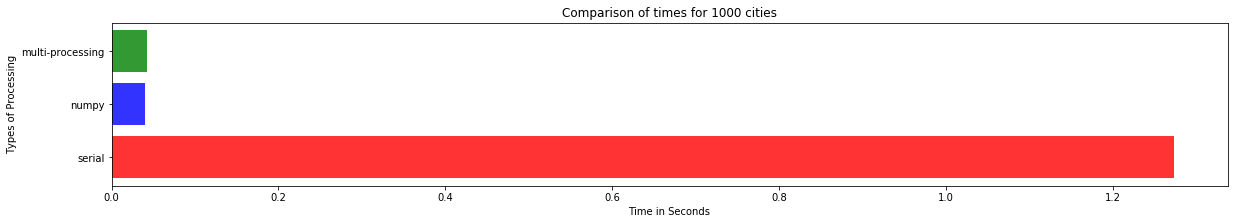

In [41]:

def main():
    n = 1000 # number of cities in the problem
    weights = np.random.random((n,n)) # square matrix of random weights for edges
    num_ants = 4

    # run the plain python version
    st04 = time.perf_counter()
    tours = construct_tours( weights, num_ants)
    st04 = time.perf_counter() - st04
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",st04)
    print()
    

    # run the numpy version - you need to implement this
    nt04 = time.perf_counter()
    tours = construct_tours_np( weights, num_ants )
    nt04 = time.perf_counter() - nt04
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",nt04)
    print()
   

    # run the multiprocessing version - you need to implement this
    mt04 = time.perf_counter()
    tours = construct_tours_mp( weights, num_ants )
    mt04 = time.perf_counter() - mt04
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",mt04)
    print()
    
    times = [st04, nt04, mt04]
    names = ('serial', 'numpy', 'multi-processing')
    y_pos = np.arange(len(names))
 
    # Create horizontal bars
    plt.barh(y_pos, times,align='center', alpha=0.8,color=['r','b','g'])

    plt.rcParams["figure.figsize"] = (20,3)
    plt.yticks(y_pos, names) 
    plt.xlabel('Time in Seconds')
    plt.ylabel('Types of Processing')
    plt.title('Comparison of times for 1000 cities')
    # Show graphic
    plt.show()

if __name__ == '__main__':
    main()

## Experiment for 1000 cities

constructed 8 tours
valid tours: True
Serial: time for 8 ants is 2.5349979269994947

constructed 8 tours
valid tours: True
Serial: time for 8 ants is 0.079723616996489

constructed 8 tours
valid tours: True
Serial: time for 8 ants is 0.06656830599968089



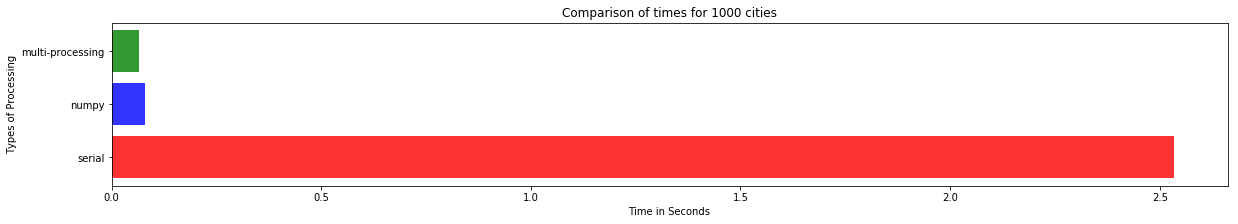

The Speedup from Serial to Multiprocessing is: 38.08115422092379
The efficiency is 4.760144277615474


In [42]:
def main():
    n = 1000 # number of cities in the problem
    weights = np.random.random((n,n)) # square matrix of random weights for edges
    num_ants = 8

    # run the plain python version
    st1 = time.perf_counter()
    tours = construct_tours( weights, num_ants)
    st1 = time.perf_counter() - st1
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",st1)
    print()
    

    # run the numpy version - you need to implement this
    nt1 = time.perf_counter()
    tours = construct_tours_np( weights, num_ants )
    nt1 = time.perf_counter() - nt1
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",nt1)
    print()
   

    # run the multiprocessing version - you need to implement this
    mt1 = time.perf_counter()
    tours = construct_tours_mp( weights, num_ants )
    mt1 = time.perf_counter() - mt1
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",mt1)
    print()
    
    times = [st1, nt1, mt1]
    names = ('serial', 'numpy', 'multi-processing')
    y_pos = np.arange(len(names))
 
    # Create horizontal bars
    plt.barh(y_pos, times,align='center', alpha=0.8,color=['r','b','g'])

    plt.rcParams["figure.figsize"] = (20,3)
    plt.yticks(y_pos, names) 
    plt.xlabel('Time in Seconds')
    plt.ylabel('Types of Processing')
    plt.title('Comparison of times for 1000 cities')
    # Show graphic
    plt.show()
    
    speedup= st1/mt1
    efficiency= speedup/8
    print('The Speedup from Serial to Multiprocessing is:', speedup)
    print('The efficiency is', efficiency)

if __name__ == '__main__':
    main()


## The run for 1000 cities shows that although the times are improved for the numpy and multiprocessing implementation, the multiprocessing time is slightly slower. This is because the time taken to distribute the processes and execute the function is longer that the time numpy can take. 

# Time for 2000 cities 

constructed 8 tours
valid tours: True
Serial: time for 8 ants is 10.178178917001787

constructed 8 tours
valid tours: True
Serial: time for 8 ants is 0.2623399600015546

constructed 8 tours
valid tours: True
Serial: time for 8 ants is 0.22418398999798228



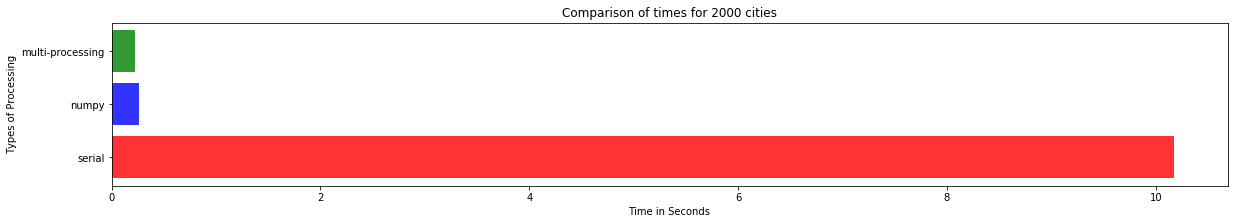

The Speedup from Serial to Multiprocessing is: 45.401007079468044
The efficiency is 5.675125884933506


In [43]:

def main():
    n = 2000 # number of cities in the problem
    weights = np.random.random((n,n)) # square matrix of random weights for edges
    num_ants = 8

    # run the plain python version
    st2 = time.perf_counter()
    tours = construct_tours( weights, num_ants)
    st2 = time.perf_counter() - st2
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",st2)
    print()
    

    # run the numpy version - you need to implement this
    nt2 = time.perf_counter()
    tours = construct_tours_np( weights, num_ants )
    nt2 = time.perf_counter() - nt2
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",nt2)
    print()
   

    # run the multiprocessing version - you need to implement this
    mt2 = time.perf_counter()
    tours = construct_tours_mp( weights, num_ants )
    mt2 = time.perf_counter() - mt2
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",mt2)
    print()
    
    times = [st2, nt2, mt2]
    names = ('serial', 'numpy', 'multi-processing')
    y_pos = np.arange(len(names))
 
    # Create horizontal bars
    plt.barh(y_pos, times,align='center', alpha=0.8,color=['r','b','g'])

    plt.rcParams["figure.figsize"] = (20,3)
    plt.yticks(y_pos, names) 
    plt.xlabel('Time in Seconds')
    plt.ylabel('Types of Processing')
    plt.title('Comparison of times for 2000 cities')
    # Show graphic
    plt.show()
    
    speedup= st2/mt2
    efficiency= speedup/8
    print('The Speedup from Serial to Multiprocessing is:', speedup)
    print('The efficiency is', efficiency)

if __name__ == '__main__':
    main()

## Now as the task requires a bigger quantity of computation, the multiprocessing is shown to be the best time (shortest) whereas the effort required for the serial version shows how the time taken is significantly more. The difference seen by the Serial and Numpy is improvement by approximately 36 fold. Furthermore the multiprocessing is a further twice as quick as the numpy version.

# Time for 4000 cities 


constructed 8 tours
valid tours: True
Serial: time for 8 ants is 41.15402221399927

constructed 8 tours
valid tours: True
Serial: time for 8 ants is 0.9881977500008361

constructed 8 tours
valid tours: True
Serial: time for 8 ants is 0.2871784929993737



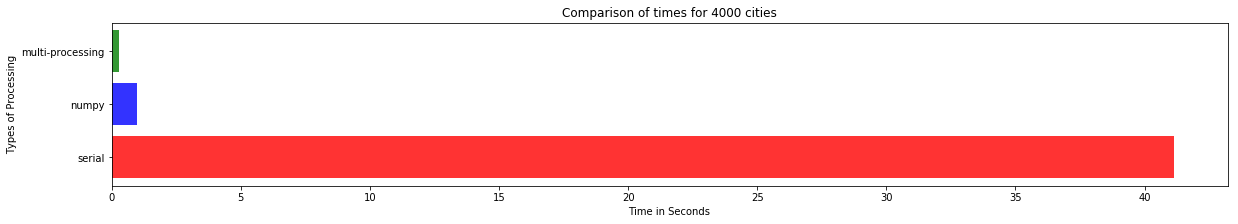

The Speedup from Serial to Multiprocessing is: 143.3046805983797
The efficiency is 17.91308507479746


In [44]:

def main():
    n = 4000 # number of cities in the problem
    weights = np.random.random((n,n)) # square matrix of random weights for edges
    num_ants = 8

    # run the plain python version
    st4 = time.perf_counter()
    tours = construct_tours( weights, num_ants)
    st4 = time.perf_counter() - st4
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",st4)
    print()
    

    # run the numpy version - you need to implement this
    nt4 = time.perf_counter()
    tours = construct_tours_np( weights, num_ants )
    nt4 = time.perf_counter() - nt4
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",nt4)
    print()
   

    # run the multiprocessing version - you need to implement this
    mt4 = time.perf_counter()
    tours = construct_tours_mp( weights, num_ants )
    mt4 = time.perf_counter() - mt4
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",mt4)
    print()
    
    times = [st4, nt4, mt4]
    names = ('serial', 'numpy', 'multi-processing')
    y_pos = np.arange(len(names))
 
    # Create horizontal bars
    plt.barh(y_pos, times,align='center', alpha=0.8,color=['r','b','g'])

    plt.rcParams["figure.figsize"] = (20,3)
    plt.yticks(y_pos, names) 
    plt.xlabel('Time in Seconds')
    plt.ylabel('Types of Processing')
    plt.title('Comparison of times for 4000 cities')
    # Show graphic
    plt.show()

    speedup= st4/mt4
    efficiency= speedup/8
    print('The Speedup from Serial to Multiprocessing is:', speedup)
    print('The efficiency is', efficiency)
    
if __name__ == '__main__':
    main()

## This implementation  using 4000 cities, it shows that the Serial time is takes longer as expected and the difference in the number of fold increase has improved with the difference between Serial to Numpy reaching 40 fold and the multiprocessing making an improvement of just under 3 fold further.


# Time for 8000 cities 

constructed 8 tours
valid tours: True
Serial: time for 8 ants is 163.8235743360019

constructed 8 tours
valid tours: True
Serial: time for 8 ants is 3.7606726910016732

constructed 8 tours
valid tours: True
Serial: time for 8 ants is 0.8870245170000999



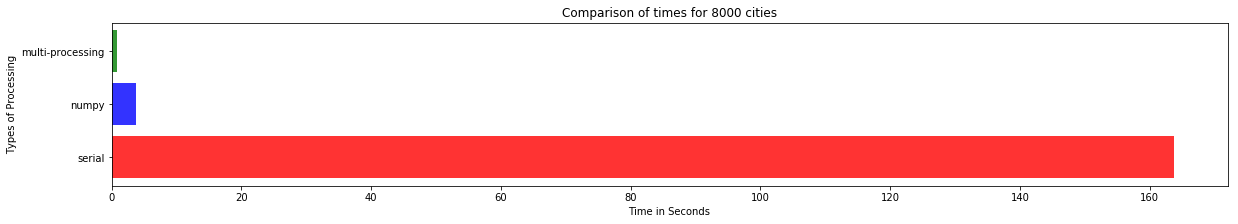

The Speedup from Serial to Multiprocessing is: 184.6888910016266
The efficiency is 23.086111375203323


In [45]:

def main():
    n = 8000 # number of cities in the problem
    weights = np.random.random((n,n)) # square matrix of random weights for edges
    num_ants = 8

    # run the plain python version
    st8 = time.perf_counter()
    tours = construct_tours( weights, num_ants)
    st8 = time.perf_counter() - st8
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",st8)
    print()
    

    # run the numpy version - you need to implement this
    nt8 = time.perf_counter()
    tours = construct_tours_np( weights, num_ants )
    nt8 = time.perf_counter() - nt8
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",nt8)
    print()
   

    # run the multiprocessing version - you need to implement this
    mt8 = time.perf_counter()
    tours = construct_tours_mp( weights, num_ants )
    mt8 = time.perf_counter() - mt8
    print("constructed",len(tours),"tours")
    print("valid tours:",check_tours(tours, n))
    print("Serial: time for",num_ants,"ants is",mt8)
    print()
    
    times = [st8, nt8, mt8]
    names = ('serial', 'numpy', 'multi-processing')
    y_pos = np.arange(len(names))
 
    # Create horizontal bars
    plt.barh(y_pos, times,align='center', alpha=0.8,color=['r','b','g'])

    plt.rcParams["figure.figsize"] = (20,3)
    plt.yticks(y_pos, names) 
    plt.xlabel('Time in Seconds')
    plt.ylabel('Types of Processing')
    plt.title('Comparison of times for 8000 cities')
    # Show graphic
    plt.show()
    
    speedup= st8/mt8
    efficiency= speedup/8
    print('The Speedup from Serial to Multiprocessing is:', speedup)
    print('The efficiency is', efficiency)

if __name__ == '__main__':
    main()

## As shown the number of citites increases and so does the rate of computation for each implementation. This shows in this instance where the number of processors is 8, the ability to partition the work and split the processes set by multiprocessing still gives it a time to produce the time to under 1 second whereas numpy is still optimised but not as well even with the increase of over 40 fold. 


## The speedup and number of fold increase shows that there is a sub-linear speed up because the rate of speed-up is not contstantly half the time, with the efficiency increasing similarly.

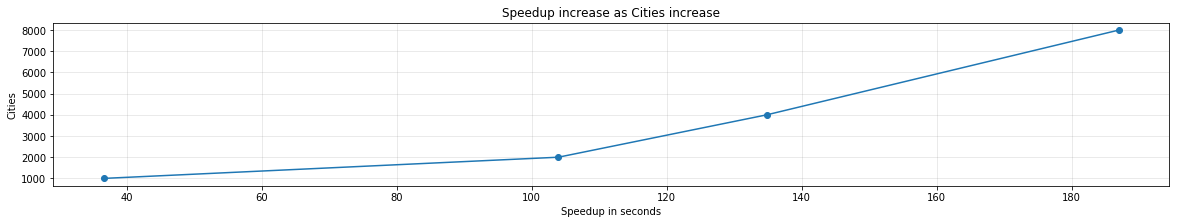

In [46]:
def main():
    n = 1000 # number of cities in the problem
    weights = np.random.random((n,n)) # square matrix of random weights for edges
    num_ants = 8

    st = time.perf_counter()
    tours = construct_tours( weights, num_ants)
    st = time.perf_counter() - st
    
    nt = time.perf_counter()
    tours = construct_tours_np( weights, num_ants )
    nt = time.perf_counter() - nt
   

    mt = time.perf_counter()
    tours = construct_tours_mp( weights, num_ants )
    mt = time.perf_counter() - mt

    
    n = 2000 # number of cities in the problem
    weights = np.random.random((n,n)) # square matrix of random weights for edges
    num_ants = 8

    st2 = time.perf_counter()
    tours = construct_tours( weights, num_ants)
    st2 = time.perf_counter() - st2
    

    nt2 = time.perf_counter()
    tours = construct_tours_np( weights, num_ants )
    nt2 = time.perf_counter() - nt2
    

    mt2 = time.perf_counter()
    tours = construct_tours_mp( weights, num_ants )
    mt2 = time.perf_counter() - mt2
    
    
    n = 4000 # number of cities in the problem
    weights = np.random.random((n,n)) # square matrix of random weights for edges
    num_ants = 8

    st4 = time.perf_counter()
    tours = construct_tours( weights, num_ants)
    st4 = time.perf_counter() - st4
        
    nt4 = time.perf_counter()
    tours = construct_tours_np( weights, num_ants )
    nt4 = time.perf_counter() - nt4
       
    mt4 = time.perf_counter()
    tours = construct_tours_mp( weights, num_ants )
    mt4 = time.perf_counter() - mt4
    
    
    n = 8000 # number of cities in the problem
    weights = np.random.random((n,n)) # square matrix of random weights for edges
    num_ants = 8

    st8 = time.perf_counter()
    tours = construct_tours( weights, num_ants)
    st8 = time.perf_counter() - st8
    
    nt8 = time.perf_counter()
    tours = construct_tours_np( weights, num_ants )
    nt8 = time.perf_counter() - nt8
       
    mt8 = time.perf_counter()
    tours = construct_tours_mp( weights, num_ants )
    mt8 = time.perf_counter() - mt8
        
    speedup1= st/mt
    speedup2= st2/mt2
    speedup4= st4/mt4
    speedup8= st8/mt8
    
    speeds = [speedup1, speedup2, speedup4, speedup8]
    cities = (1000, 2000, 4000, 8000)
    plt.grid(b=True, color='grey', linestyle='-', alpha=0.2)
    plt.plot(speeds, cities, marker='o')
    plt.ylabel('Cities')
    plt.xlabel('Speedup in seconds')
    plt.title('Speedup increase as Cities increase')
    plt.show()


if __name__ == '__main__':
    main()

### As shown above, the speedup increases in a non-linear but gradual fashion, where the gradient reflects the increase over number of cities

# System being used:

In [47]:
import platform

def print_sysinfo():

    print('\nPython version  :', platform.python_version())

    print('\nsystem     :', platform.system())
    print('CPU count  :', mp.cpu_count())
    print('interpreter:', platform.architecture()[0])
    print('\n\n')
print_sysinfo()


Python version  : 3.5.3

system     : Linux
CPU count  : 8
interpreter: 64bit



